In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import datetime
import time
from datetime import date 
from sentence_transformers import SentenceTransformer
import re

df = pd.read_csv('CAvideos_filtered_with_durations_2.csv')
df_1 = pd.read_json("CA_category_id.json")
df_categories = pd.json_normalize(df_1['items'])
df_categories = df_categories[['id', 'snippet.title']]
df_categories.columns = ['Category ID', 'Category Title']
print(df_categories)

df.loc[df['comments_disabled'] == True, 'comment_count'] = 1

def clean_description(description):
    description = re.sub(r'http[s]?://\S+|www\.\S+', '', description)
    description = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', description)
    description = ' '.join(description.split())
    return description

df['description'] = df['description'].astype(str).apply(clean_description)

print("\nKiểm tra description sau khi làm sạch (5 mẫu đầu tiên):")
print(df[['description']].head())

def combine_text(row):
    return f"{row['title']} [SEP] {row['description']} [SEP] {row['tags']}"

df['text_combined'] = df.apply(combine_text, axis=1)
df.head()


   Category ID        Category Title
0            1      Film & Animation
1            2      Autos & Vehicles
2           10                 Music
3           15        Pets & Animals
4           17                Sports
5           18          Short Movies
6           19       Travel & Events
7           20                Gaming
8           21         Videoblogging
9           22        People & Blogs
10          23                Comedy
11          24         Entertainment
12          25       News & Politics
13          26         Howto & Style
14          27             Education
15          28  Science & Technology
16          30                Movies
17          31       Anime/Animation
18          32      Action/Adventure
19          33              Classics
20          34                Comedy
21          35           Documentary
22          36                 Drama
23          37                Family
24          38               Foreign
25          39                Horror


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,video_durations,text_combined
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminems new track Walk on Water ft. Beyonc is ...,305.0,Eminem - Walk On Water (Audio) ft. Beyoncé [SE...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,575.0,PLUSH - Bad Unboxing Fan Mail [SEP] STill got ...
2,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know its been a while since we did this show...,733.0,I Dare You: GOING BALD!? [SEP] I know its been...
3,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,to Eds channel Ed on...nFacebook Website Jason...,280.0,Ed Sheeran - Perfect (Official Music Video) [S...
4,0yIWz1XEeyc,17.14.11,Jake Paul Says Alissa Violet CHEATED with LOGA...,DramaAlert,25,2017-11-13T07:37:51.000Z,"#DramaAlert|""Drama""|""Alert""|""DramaAlert""|""keem...",1309699,103755,4613,12143,https://i.ytimg.com/vi/0yIWz1XEeyc/default.jpg,False,False,False,Follow for News! Also follow DramaAlert onn In...,520.0,Jake Paul Says Alissa Violet CHEATED with LOGA...


In [2]:

model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = df['text_combined'].tolist()
embeddings = model.encode(sentences, show_progress_bar=True)

df['text_embeddings'] = embeddings.tolist()

print(df[['text_combined', 'text_embeddings']].head())

Batches:   0%|          | 0/990 [00:00<?, ?it/s]

                                       text_combined  \
0  Eminem - Walk On Water (Audio) ft. Beyoncé [SE...   
1  PLUSH - Bad Unboxing Fan Mail [SEP] STill got ...   
2  I Dare You: GOING BALD!? [SEP] I know its been...   
3  Ed Sheeran - Perfect (Official Music Video) [S...   
4  Jake Paul Says Alissa Violet CHEATED with LOGA...   

                                     text_embeddings  
0  [-0.0554160550236702, -0.12297757714986801, 0....  
1  [-0.05443856492638588, -0.10136731714010239, 0...  
2  [-0.08876512199640274, -0.006822456605732441, ...  
3  [-0.05542059242725372, -0.08617997914552689, 0...  
4  [-0.05899236351251602, -0.09303764998912811, -...  


In [3]:
def calculate_score(row):
    # Tránh lỗi chia cho 0 nếu views = 0 hoặc (likes + dislikes) = 0
    
    return (row['comment_count'] / row['views']) * \
           (row['likes'] - 1.5*row['dislikes'])

# Áp dụng cho từng hàng trong DataFrame
df['Score'] = df.apply(calculate_score, axis=1)
df.head()
import pandas as pd
# Define the labeling function based on Score and Views
def classify_based_on_score(row):
    if row['views'] < 100000:
        return 0
    elif row['views'] >= 100000 and row['Score'] < 0:
        return 1
    elif row['views'] >= 100000 and 0 <= row['Score'] < 500:
        return 2
    elif row['views'] >= 100000 and row['Score'] >= 500:
        return 3

df['Y'] = df.apply(classify_based_on_score, axis=1)
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,video_durations,text_combined,text_embeddings,Score,Y
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminems new track Walk on Water ft. Beyonc is ...,305.0,Eminem - Walk On Water (Audio) ft. Beyoncé [SE...,"[-0.0554160550236702, -0.12297757714986801, 0....",5299.036662,3
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,575.0,PLUSH - Bad Unboxing Fan Mail [SEP] STill got ...,"[-0.05443856492638588, -0.10136731714010239, 0...",1608.596315,3
2,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,...,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know its been a while since we did this show...,733.0,I Dare You: GOING BALD!? [SEP] I know its been...,"[-0.08876512199640274, -0.006822456605732441, ...",1080.383433,3
3,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,...,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,to Eds channel Ed on...nFacebook Website Jason...,280.0,Ed Sheeran - Perfect (Official Music Video) [S...,"[-0.05542059242725372, -0.08617997914552689, 0...",4066.400193,3
4,0yIWz1XEeyc,17.14.11,Jake Paul Says Alissa Violet CHEATED with LOGA...,DramaAlert,25,2017-11-13T07:37:51.000Z,"#DramaAlert|""Drama""|""Alert""|""DramaAlert""|""keem...",1309699,103755,4613,...,https://i.ytimg.com/vi/0yIWz1XEeyc/default.jpg,False,False,False,Follow for News! Also follow DramaAlert onn In...,520.0,Jake Paul Says Alissa Violet CHEATED with LOGA...,"[-0.05899236351251602, -0.09303764998912811, -...",897.819634,3


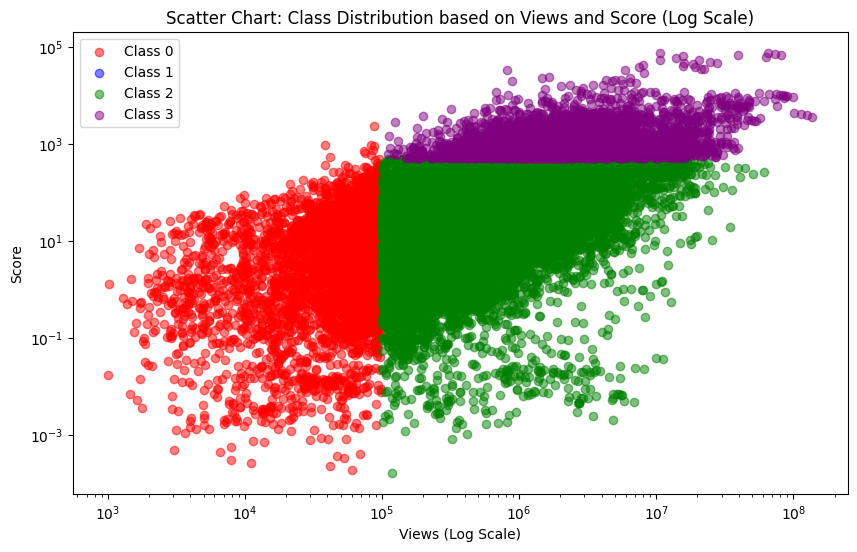

In [4]:
plt.figure(figsize=(10, 6))

# Class 0 (Views < 100,000)
class_0 = df[df['Y'] == 0]
plt.scatter(class_0['views'], class_0['Score'], label='Class 0', color='red', alpha=0.5)

# Class 1 (Views >= 100,000 and Score < 0)
class_1 = df[df['Y'] == 1]
plt.scatter(class_1['views'], class_1['Score'], label='Class 1', color='blue', alpha=0.5)

# Class 2 (Views >= 100,000 and 0 <= Score < 500)
class_2 = df[df['Y'] == 2]
plt.scatter(class_2['views'], class_2['Score'], label='Class 2', color='green', alpha=0.5)

# Class 3 (Views >= 100,000 and Score >= 500)
class_3 = df[df['Y'] == 3]
plt.scatter(class_3['views'], class_3['Score'], label='Class 3', color='purple', alpha=0.5)

plt.xscale('log')
plt.yscale('log')

plt.title("Scatter Chart: Class Distribution based on Views and Score (Log Scale)")
plt.xlabel("Views (Log Scale)")
plt.ylabel("Score")
plt.legend()

# Show the plot
plt.show()


In [5]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,video_durations,text_combined,text_embeddings,Score,Y
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminems new track Walk on Water ft. Beyonc is ...,305.0,Eminem - Walk On Water (Audio) ft. Beyoncé [SE...,"[-0.0554160550236702, -0.12297757714986801, 0....",5299.036662,3
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,575.0,PLUSH - Bad Unboxing Fan Mail [SEP] STill got ...,"[-0.05443856492638588, -0.10136731714010239, 0...",1608.596315,3
2,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,...,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know its been a while since we did this show...,733.0,I Dare You: GOING BALD!? [SEP] I know its been...,"[-0.08876512199640274, -0.006822456605732441, ...",1080.383433,3
3,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,...,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,to Eds channel Ed on...nFacebook Website Jason...,280.0,Ed Sheeran - Perfect (Official Music Video) [S...,"[-0.05542059242725372, -0.08617997914552689, 0...",4066.400193,3
4,0yIWz1XEeyc,17.14.11,Jake Paul Says Alissa Violet CHEATED with LOGA...,DramaAlert,25,2017-11-13T07:37:51.000Z,"#DramaAlert|""Drama""|""Alert""|""DramaAlert""|""keem...",1309699,103755,4613,...,https://i.ytimg.com/vi/0yIWz1XEeyc/default.jpg,False,False,False,Follow for News! Also follow DramaAlert onn In...,520.0,Jake Paul Says Alissa Violet CHEATED with LOGA...,"[-0.05899236351251602, -0.09303764998912811, -...",897.819634,3


In [6]:
from datetime import datetime

df["publish_time"] = pd.to_datetime(df["publish_time"].str.replace("Z", ""), format="%Y-%m-%dT%H:%M:%S.%f")
df["trending_date"] = pd.to_datetime(df["trending_date"], format="%y.%d.%m")
df["days_to_trending"] = (df["trending_date"] - df["publish_time"]).dt.days
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,comments_disabled,ratings_disabled,video_error_or_removed,description,video_durations,text_combined,text_embeddings,Score,Y,days_to_trending
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10 17:00:03,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,False,False,False,Eminems new track Walk on Water ft. Beyonc is ...,305.0,Eminem - Walk On Water (Audio) ft. Beyoncé [SE...,"[-0.0554160550236702, -0.12297757714986801, 0....",5299.036662,3,3
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13 17:00:00,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,False,False,False,STill got a lot of packages. Probably will las...,575.0,PLUSH - Bad Unboxing Fan Mail [SEP] STill got ...,"[-0.05443856492638588, -0.10136731714010239, 0...",1608.596315,3,0
2,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,...,False,False,False,I know its been a while since we did this show...,733.0,I Dare You: GOING BALD!? [SEP] I know its been...,"[-0.08876512199640274, -0.006822456605732441, ...",1080.383433,3,1
3,2Vv-BfVoq4g,2017-11-14,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09 11:04:14,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,...,False,False,False,to Eds channel Ed on...nFacebook Website Jason...,280.0,Ed Sheeran - Perfect (Official Music Video) [S...,"[-0.05542059242725372, -0.08617997914552689, 0...",4066.400193,3,4
4,0yIWz1XEeyc,2017-11-14,Jake Paul Says Alissa Violet CHEATED with LOGA...,DramaAlert,25,2017-11-13 07:37:51,"#DramaAlert|""Drama""|""Alert""|""DramaAlert""|""keem...",1309699,103755,4613,...,False,False,False,Follow for News! Also follow DramaAlert onn In...,520.0,Jake Paul Says Alissa Violet CHEATED with LOGA...,"[-0.05899236351251602, -0.09303764998912811, -...",897.819634,3,0


In [7]:
df.to_pickle('data_with_embeddings_fix.pkl')

print("Đã lưu dữ liệu vào file data_with_embeddings.pkl")

Đã lưu dữ liệu vào file data_with_embeddings.pkl


In [9]:
df.to_csv('data_with_embedding_csv.csv')